In [26]:
import nltk
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA, TruncatedSVD


In [2]:

import gensim
word2vec_path = "../../Libraries/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [3]:
inputFile="../data/labeled/labeled_dataV1.csv"
df = pd.read_csv(inputFile)
#df=df[0:500000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
 



labeled_data=df[df['class']!= '-1'].copy()

#encode the classes to their index 
labeled_data['labels']=labeled_data['class'].apply( classes.index)
print(classes)


['unisex', 'men', 'women', 'kid', 'baby']


# Bag of Words Counts 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = labeled_data["all_text"].tolist()
list_labels = labeled_data["labels"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, 
                                                    list_labels, test_size=0.2,
                                                     random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_counts.shape

(49033, 153035)

## Enter word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.# 

In [5]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, tokenized_text ,generate_missing=False):
    embeddings = data[tokenized_text].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [6]:
embeddings = get_word2vec_embeddings(word2vec, labeled_data, 'all_tokens')
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [29]:



def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red', 'yellow', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Unisex')
            blue_patch = mpatches.Patch(color='blue', label='Men')
            red_patch = mpatches.Patch(color='red', label='Women')
            yellow_patch = mpatches.Patch(color='yellow', label='Kids')
            green_patch = mpatches.Patch(color='black', label='Baby')
            plt.legend(handles=[orange_patch, blue_patch, red_patch,yellow_patch, green_patch], prop={'size': 10})


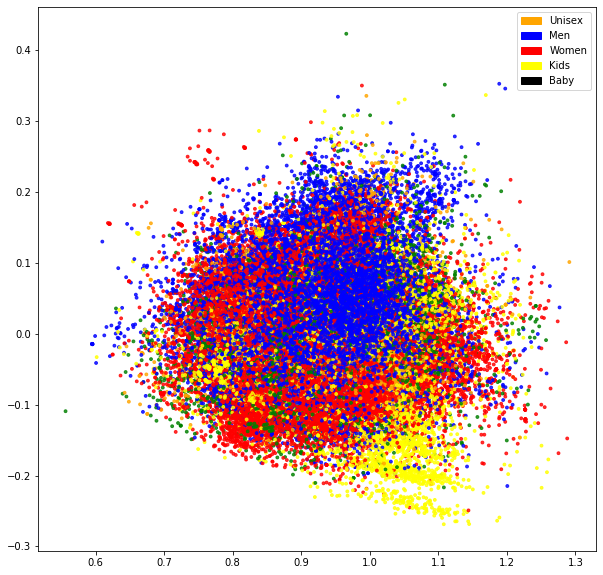

In [30]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

## Fitting logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.560, precision = 0.594, recall = 0.560, f1 = 0.565


In [15]:

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

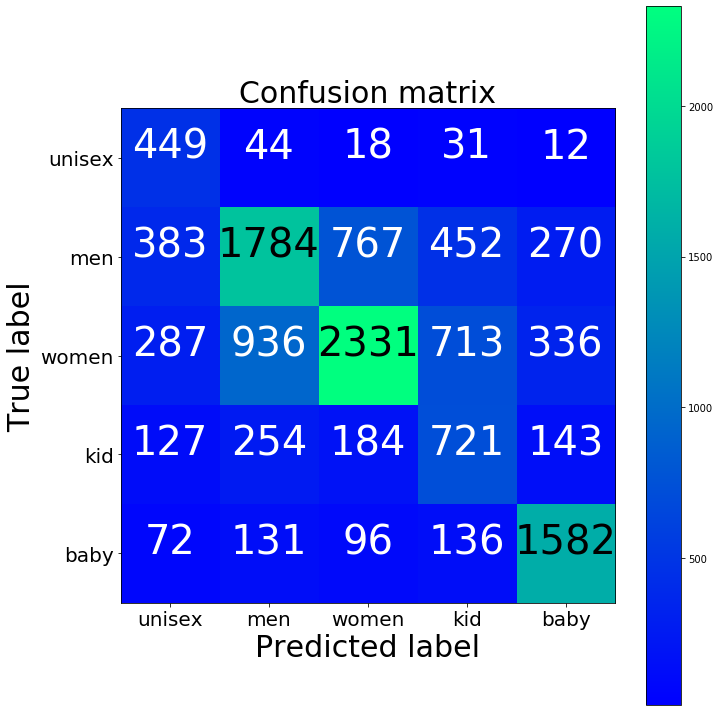

Word2Vec confusion matrix
[[ 449   44   18   31   12]
 [ 383 1784  767  452  270]
 [ 287  936 2331  713  336]
 [ 127  254  184  721  143]
 [  72  131   96  136 1582]]


In [33]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
 
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm,classes=classes, normalize=False, title='Confusion matrix')

plt.show()
print("Word2Vec confusion matrix")
print(cm)


 
 


